In [1]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
api_key = ''

In [3]:
channel_ids = ['UCBJycsmduvYEL83R_U4JriQ'],
               # more channels here
      

In [4]:

api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [5]:
def get_channel_stats(youtube, channel_ids):
    
    """
    Get channel stats
    
    Params:
    ------
    youtube: build object of Youtube API
    channel_ids: list of channel IDs
    
    Returns:
    ------
    dataframe with all channel stats for each channel ID
    
    """
    
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids
    
    
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [6]:
# Assuming channel_ids is a nested list
channel_ids_flat = [channel_id for sublist in channel_ids for channel_id in sublist]


In [7]:
channel_stats = get_channel_stats(youtube, channel_ids_flat)


In [8]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Marques Brownlee,18400000,4073677501,1631,UUBJycsmduvYEL83R_U4JriQ


In [9]:
playlist_id = "UUBJycsmduvYEL83R_U4JriQ"

In [10]:
# Get video IDs
video_ids = get_video_ids(youtube, playlist_id)

In [11]:

len(video_ids)

1627

In [12]:
# Get video details
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,hOi8s2wkX4A,Marques Brownlee,Apple Vision Pro is Missing Something...,I already have a wishlist for the next generat...,"[Vision Pro, Apple Vision Pro, Apple VR, Apple...",2024-02-13T01:13:02Z,3005516,96348,None,7122,PT13M48S,hd,true
1,CjWfgSrwrz0,Marques Brownlee,Apple Vision Pro Hidden Feature ✈️ #protip,It works best on airplanes,None,2024-02-09T22:20:23Z,3347424,168320,None,1116,PT1M,hd,false
2,B-d97ZrAJZ0,Marques Brownlee,OnePlus 12 Review: Better Than You Think!,Specced to the max and priced to crush.\n\nMKB...,"[OnePlus 12, OnePlus 12 Review, OnePlus 12 vs,...",2024-02-09T03:45:25Z,2067495,71395,None,4070,PT14M50S,hd,true
3,dMObcjEI50w,Marques Brownlee,In case you’re having a bad day,You'll never be less valued than this...,None,2024-02-04T20:02:06Z,2267035,152278,None,2901,PT1M,hd,false
4,86Gy035z_KA,Marques Brownlee,Apple Vision Pro Review: Tomorrow's Ideas... T...,Apple Vision Pro is a glimpse into the future....,"[Apple Vision Pro, Vision Pro, Apple Vision, M...",2024-02-04T01:40:14Z,7609564,204090,None,12047,PT24M48S,hd,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1622,hCEBLSSU-2Y,Marques Brownlee,Fraps HD Test in 1080p (18 WOS),"***WATCH IN HD***\r\n\r\nAlso, check out my vi...","[fraps, hd, high, definition, 720, 1080, 18, w...",2009-01-01T22:30:32Z,146269,1763,None,240,PT1M31S,hd,false
1623,9gk_rl3y_SU,Marques Brownlee,HP Pavilion dv7t Media Center Remote Overview,This is my short review of the Media Center Re...,"[hp, pavilion, dv7, laptop, 17, inch, desktop,...",2009-01-01T19:43:47Z,4858003,239741,None,36661,PT2M51S,sd,false
1624,f7mqssf66l4,Marques Brownlee,High fps LG Voyager footage,This video was uploaded directly from my LG Vo...,"[mobile, video, cellphone, high, fps, footage,...",2008-09-16T01:33:42Z,204808,2968,None,756,PT31S,sd,false
1625,PD5igzFB8iY,Marques Brownlee,14 Year knock-down shot (11 Handicap),"Me hitting a knock-down shot with a six iron, ...","[golf, tiger, woods, prodigy, amazing, analysi...",2008-05-30T20:27:17Z,192422,2464,None,375,PT41S,sd,false


## Data pre-processing

In [13]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount          True
likeCount          True
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

In [14]:
# Check data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [15]:
video_df.describe()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
count,1627,1627,1627,1627,1544,1627,1620,1614,0,1608,1627,1627,1627
unique,1627,1,1623,1619,1526,1627,1617,1481,0,1299,781,2,2
top,hOi8s2wkX4A,Marques Brownlee,MKBHD Update 6.0,,"[Marques Brownlee, MKBHD, Vox, Tech, Retro, Re...",2024-02-13T01:13:02Z,5871,80,NaN,20,PT1M,hd,false
freq,1,1627,2,8,11,1,2,7,NaN,14,33,1595,1383


In [16]:
video_df.shape

(1627, 13)

In [17]:
video_df.head(5)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,hOi8s2wkX4A,Marques Brownlee,Apple Vision Pro is Missing Something...,I already have a wishlist for the next generat...,"[Vision Pro, Apple Vision Pro, Apple VR, Apple...",2024-02-13T01:13:02Z,3005516,96348,None,7122,PT13M48S,hd,true
1,CjWfgSrwrz0,Marques Brownlee,Apple Vision Pro Hidden Feature ✈️ #protip,It works best on airplanes,None,2024-02-09T22:20:23Z,3347424,168320,None,1116,PT1M,hd,false
2,B-d97ZrAJZ0,Marques Brownlee,OnePlus 12 Review: Better Than You Think!,Specced to the max and priced to crush.\n\nMKB...,"[OnePlus 12, OnePlus 12 Review, OnePlus 12 vs,...",2024-02-09T03:45:25Z,2067495,71395,None,4070,PT14M50S,hd,true
3,dMObcjEI50w,Marques Brownlee,In case you’re having a bad day,You'll never be less valued than this...,None,2024-02-04T20:02:06Z,2267035,152278,None,2901,PT1M,hd,false
4,86Gy035z_KA,Marques Brownlee,Apple Vision Pro Review: Tomorrow's Ideas... T...,Apple Vision Pro is a glimpse into the future....,"[Apple Vision Pro, Vision Pro, Apple Vision, M...",2024-02-04T01:40:14Z,7609564,204090,None,12047,PT24M48S,hd,true


In [18]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)


In [19]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [20]:
video_df[['durationSecs', 'duration']]

,durationSecs,duration
0,0 days 00:13:48,PT13M48S
1,0 days 00:01:00,PT1M
2,0 days 00:14:50,PT14M50S
3,0 days 00:01:00,PT1M
4,0 days 00:24:48,PT24M48S
...,...,...
1622,0 days 00:01:31,PT1M31S
1623,0 days 00:02:51,PT2M51S
1624,0 days 00:00:31,PT31S
1625,0 days 00:00:41,PT41S


In [21]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [22]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,durationSecs,tagCount
0,hOi8s2wkX4A,Marques Brownlee,Apple Vision Pro is Missing Something...,I already have a wishlist for the next generat...,"[Vision Pro, Apple Vision Pro, Apple VR, Apple...",2024-02-13T01:13:02Z,3005516.0,96348.0,NaN,7122.0,PT13M48S,hd,true,0 days 00:13:48,11
1,CjWfgSrwrz0,Marques Brownlee,Apple Vision Pro Hidden Feature ✈️ #protip,It works best on airplanes,None,2024-02-09T22:20:23Z,3347424.0,168320.0,NaN,1116.0,PT1M,hd,false,0 days 00:01:00,0
2,B-d97ZrAJZ0,Marques Brownlee,OnePlus 12 Review: Better Than You Think!,Specced to the max and priced to crush.\n\nMKB...,"[OnePlus 12, OnePlus 12 Review, OnePlus 12 vs,...",2024-02-09T03:45:25Z,2067495.0,71395.0,NaN,4070.0,PT14M50S,hd,true,0 days 00:14:50,9
3,dMObcjEI50w,Marques Brownlee,In case you’re having a bad day,You'll never be less valued than this...,None,2024-02-04T20:02:06Z,2267035.0,152278.0,NaN,2901.0,PT1M,hd,false,0 days 00:01:00,0
4,86Gy035z_KA,Marques Brownlee,Apple Vision Pro Review: Tomorrow's Ideas... T...,Apple Vision Pro is a glimpse into the future....,"[Apple Vision Pro, Vision Pro, Apple Vision, M...",2024-02-04T01:40:14Z,7609564.0,204090.0,NaN,12047.0,PT24M48S,hd,true,0 days 00:24:48,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1622,hCEBLSSU-2Y,Marques Brownlee,Fraps HD Test in 1080p (18 WOS),"***WATCH IN HD***\r\n\r\nAlso, check out my vi...","[fraps, hd, high, definition, 720, 1080, 18, w...",2009-01-01T22:30:32Z,146269.0,1763.0,NaN,240.0,PT1M31S,hd,false,0 days 00:01:31,14
1623,9gk_rl3y_SU,Marques Brownlee,HP Pavilion dv7t Media Center Remote Overview,This is my short review of the Media Center Re...,"[hp, pavilion, dv7, laptop, 17, inch, desktop,...",2009-01-01T19:43:47Z,4858003.0,239741.0,NaN,36661.0,PT2M51S,sd,false,0 days 00:02:51,10
1624,f7mqssf66l4,Marques Brownlee,High fps LG Voyager footage,This video was uploaded directly from my LG Vo...,"[mobile, video, cellphone, high, fps, footage,...",2008-09-16T01:33:42Z,204808.0,2968.0,NaN,756.0,PT31S,sd,false,0 days 00:00:31,12
1625,PD5igzFB8iY,Marques Brownlee,14 Year knock-down shot (11 Handicap),"Me hitting a knock-down shot with a six iron, ...","[golf, tiger, woods, prodigy, amazing, analysi...",2008-05-30T20:27:17Z,192422.0,2464.0,NaN,375.0,PT41S,sd,false,0 days 00:00:41,14


# Eploritory Data Analysis

### Best performing videos

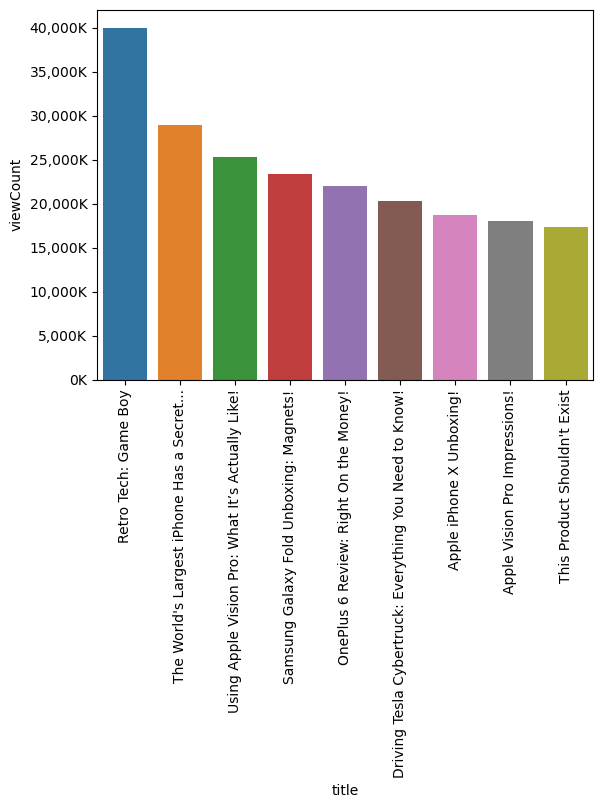

In [23]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

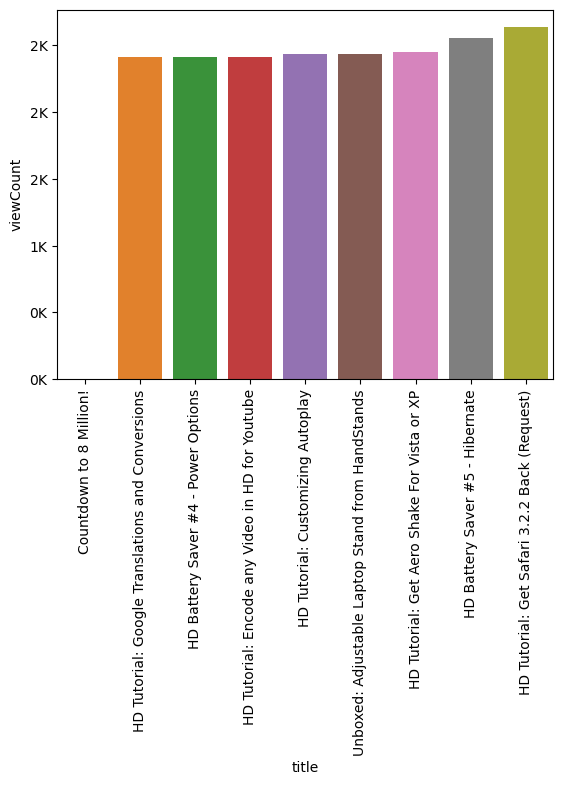

In [24]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

<Axes: xlabel='channelTitle', ylabel='viewCount'>

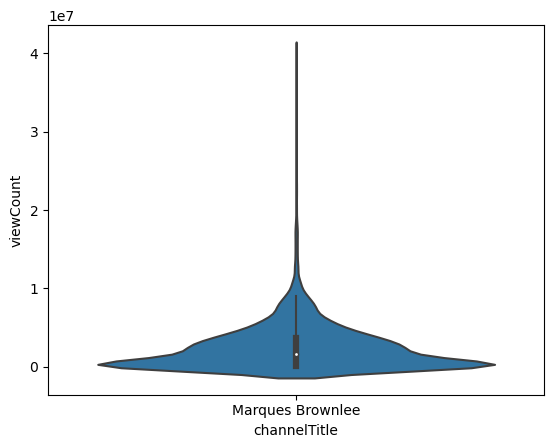

In [25]:
sns.violinplot(x='channelTitle', y='viewCount', data=video_df)



<Axes: xlabel='likeCount', ylabel='viewCount'>

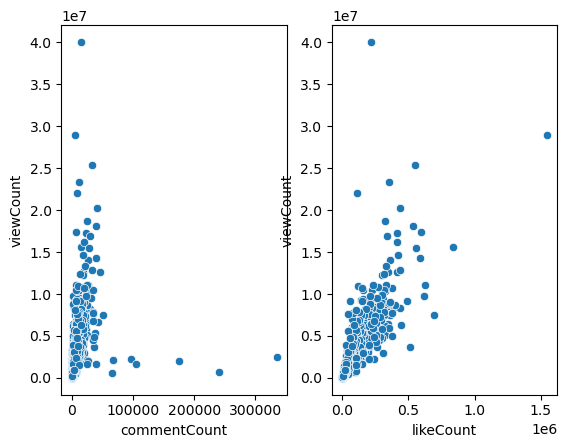

In [26]:
ig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

### Upload schedule

In [27]:

video_df['publishedAt'] = pd.to_datetime(video_df['publishedAt'])  # Convert to datetime format
video_df['publishDayName'] = video_df['publishedAt'].dt.day_name()  # Extract day of the week


In [28]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,durationSecs,tagCount,publishDayName
0,hOi8s2wkX4A,Marques Brownlee,Apple Vision Pro is Missing Something...,I already have a wishlist for the next generat...,"[Vision Pro, Apple Vision Pro, Apple VR, Apple...",2024-02-13 01:13:02+00:00,3005516.0,96348.0,NaN,7122.0,PT13M48S,hd,true,0 days 00:13:48,11,Tuesday
1,CjWfgSrwrz0,Marques Brownlee,Apple Vision Pro Hidden Feature ✈️ #protip,It works best on airplanes,None,2024-02-09 22:20:23+00:00,3347424.0,168320.0,NaN,1116.0,PT1M,hd,false,0 days 00:01:00,0,Friday
2,B-d97ZrAJZ0,Marques Brownlee,OnePlus 12 Review: Better Than You Think!,Specced to the max and priced to crush.\n\nMKB...,"[OnePlus 12, OnePlus 12 Review, OnePlus 12 vs,...",2024-02-09 03:45:25+00:00,2067495.0,71395.0,NaN,4070.0,PT14M50S,hd,true,0 days 00:14:50,9,Friday
3,dMObcjEI50w,Marques Brownlee,In case you’re having a bad day,You'll never be less valued than this...,None,2024-02-04 20:02:06+00:00,2267035.0,152278.0,NaN,2901.0,PT1M,hd,false,0 days 00:01:00,0,Sunday
4,86Gy035z_KA,Marques Brownlee,Apple Vision Pro Review: Tomorrow's Ideas... T...,Apple Vision Pro is a glimpse into the future....,"[Apple Vision Pro, Vision Pro, Apple Vision, M...",2024-02-04 01:40:14+00:00,7609564.0,204090.0,NaN,12047.0,PT24M48S,hd,true,0 days 00:24:48,12,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1622,hCEBLSSU-2Y,Marques Brownlee,Fraps HD Test in 1080p (18 WOS),"***WATCH IN HD***\r\n\r\nAlso, check out my vi...","[fraps, hd, high, definition, 720, 1080, 18, w...",2009-01-01 22:30:32+00:00,146269.0,1763.0,NaN,240.0,PT1M31S,hd,false,0 days 00:01:31,14,Thursday
1623,9gk_rl3y_SU,Marques Brownlee,HP Pavilion dv7t Media Center Remote Overview,This is my short review of the Media Center Re...,"[hp, pavilion, dv7, laptop, 17, inch, desktop,...",2009-01-01 19:43:47+00:00,4858003.0,239741.0,NaN,36661.0,PT2M51S,sd,false,0 days 00:02:51,10,Thursday
1624,f7mqssf66l4,Marques Brownlee,High fps LG Voyager footage,This video was uploaded directly from my LG Vo...,"[mobile, video, cellphone, high, fps, footage,...",2008-09-16 01:33:42+00:00,204808.0,2968.0,NaN,756.0,PT31S,sd,false,0 days 00:00:31,12,Tuesday
1625,PD5igzFB8iY,Marques Brownlee,14 Year knock-down shot (11 Handicap),"Me hitting a knock-down shot with a six iron, ...","[golf, tiger, woods, prodigy, amazing, analysi...",2008-05-30 20:27:17+00:00,192422.0,2464.0,NaN,375.0,PT41S,sd,false,0 days 00:00:41,14,Friday


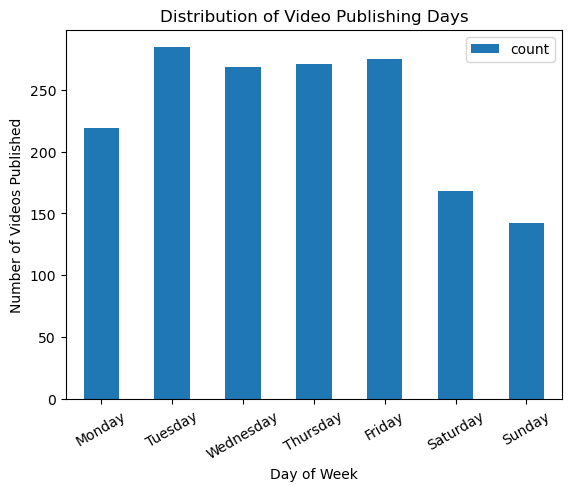

In [29]:
day_df = pd.DataFrame(video_df['publishDayName'].value_counts())
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.plot.bar(rot=30)  
plt.xlabel('Day of Week')
plt.ylabel('Number of Videos Published')
plt.title('Distribution of Video Publishing Days')
plt.show()


In [30]:
# Find the index of the row with the maximum viewCount
max_view_index = video_df['viewCount'].idxmax()

# Retrieve the publishedAt value from that row
most_watched_published_at = video_df.loc[max_view_index, 'publishedAt']

print("The most watched video was uploaded on:", most_watched_published_at)


The most watched video was uploaded on: 2019-04-19 16:00:06+00:00


In [31]:
# Find the index of the row with the maximum viewCount
max_view_index = video_df['viewCount'].idxmax()

# Retrieve all information about the most watched video using the index
most_watched_video = video_df.loc[max_view_index]

print("The most watched video is:")
print(most_watched_video)


The most watched video is:
video_id                                                Oy8zSYKkczI
channelTitle                                       Marques Brownlee
title                                          Retro Tech: Game Boy
description       The Game Boy is the most popular handheld gami...
tags              [Gameboy, Pac-Man, 1989, gaming history, unbox...
publishedAt                               2019-04-19 16:00:06+00:00
viewCount                                                40017782.0
likeCount                                                  221106.0
favouriteCount                                                  NaN
commentCount                                                14442.0
duration                                                   PT23M49S
definition                                                       hd
caption                                                        true
durationSecs                                        0 days 00:23:49
tagCount             